In [1]:
import pickle
import pandas as pd
import numpy as np
from torch_geometric.data import Data, DataLoader
import torch
import sys
sys.path.append('../src')
from incident_detection import callSpatioDevNet

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
import copy
import random

In [2]:
with open('../data/train_cases.pkl', 'rb') as f:
    train_cases = pickle.load(f)

In [3]:
with open('../data/test_cases.pkl', 'rb') as f:
    test_cases = pickle.load(f)

In [4]:
trainlist = [Data(x=torch.tensor(item['x'], dtype=torch.float), 
            edge_index=torch.tensor(item['bi_edge_index'], dtype=torch.long).t().contiguous(),
            y=torch.tensor([[1 if item['y'] == 1 else 0]], dtype = torch.float),
            edge_attr=torch.tensor(item['bi_edge_fea'], dtype = torch.float),
            global_x = torch.tensor(item['global_fea'], dtype = torch.float).unsqueeze(0)) for item in train_cases]

In [5]:
testlist = [Data(x=torch.tensor(item['x'], dtype=torch.float), 
            edge_index=torch.tensor(item['bi_edge_index'], dtype=torch.long).t().contiguous(),
            y=torch.tensor([[1 if item['y'] == 1 else 0]], dtype = torch.float),
            edge_attr=torch.tensor(item['bi_edge_fea'], dtype = torch.float),
            global_x = torch.tensor(item['global_fea'], dtype = torch.float).unsqueeze(0)) for item in test_cases]

In [6]:
train_labels = [int(item.y) for item in trainlist]

In [7]:
test_labels = [int(item.y) for item in testlist]

In [8]:
pd.Series(train_labels).value_counts()

0    2749
1     311
dtype: int64

In [9]:
pd.Series(test_labels).value_counts()

0    2745
1     315
dtype: int64

In [10]:
trainlist[0]

Data(edge_attr=[2, 7], edge_index=[2, 2], global_x=[1, 4], x=[2, 14], y=[1, 1])

In [11]:
INPUT_DIM = trainlist[0].x.shape[1]
HIDDEN_DIM = 20
EDGE_ATTR_LEN = trainlist[0].edge_attr.shape[1]
GLOBAL_FEA_LEN = trainlist[0].global_x.shape[1]

In [12]:
torch.set_num_threads(1)

# Stage 1 Demo

In [13]:
gied_ap = []
gied_prf = []
for seedi in range(5):
    NAME = 'FinalModel_OnlineBoutique'
    LOSS = 'cross_entropy'
    POOLING = 'attention'
    model = callSpatioDevNet(name = NAME, input_dim = INPUT_DIM, hidden_dim = HIDDEN_DIM, edge_attr_len = EDGE_ATTR_LEN, global_fea_len = GLOBAL_FEA_LEN, num_epochs = 60, nonlinear_scorer = False, act = False, pooling = POOLING, loss_func = LOSS, lr = 1e-3, seed = seedi)
    
    preds, preds_proba, feas = model.cold_start_predict(trainlist)
    
    gied_prf.append(precision_recall_fscore_support(train_labels, preds, average = 'binary'))
    gied_ap.append(average_precision_score(train_labels, preds_proba))

100%|██████████| 96/96 [00:00<00:00, 321.89it/s]


In [14]:
print(gied_prf)

[(0.9266666666666666, 0.8938906752411575, 0.9099836333878886, None), (0.9304635761589404, 0.9035369774919614, 0.9168026101141925, None), (0.9210526315789473, 0.9003215434083601, 0.910569105691057, None), (0.934640522875817, 0.9196141479099679, 0.927066450567261, None), (0.9215686274509803, 0.9067524115755627, 0.9141004862236628, None)]


In [15]:
print(gied_ap)

[0.9184355226427776, 0.9260066557937843, 0.9209568258896262, 0.9330816662488696, 0.9273146495613314]


# Stage 2 Demo

Epoch [60/60], Iter [90/96], total_loss: 0.0206


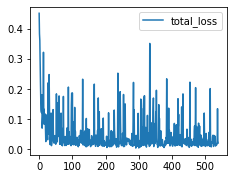

100%|██████████| 96/96 [00:00<00:00, 328.56it/s]


(0.9863013698630136, 0.9260450160771704, 0.9552238805970148, None) [0.31766644]


In [16]:
def bf_search(labels, scores):
    """
    Find the a good threshold using the training set
    Returns:
        list: list for results
        float: the `threshold` for best-f1
    """
    m = (-1., -1., -1., None)
    m_t = 0.0
    
    for threshold in sorted(list(scores))[1:-1]:
        target = precision_recall_fscore_support(labels, (scores > threshold).astype('int'), average = 'binary')
        if target[2] > m[2]:
            m_t = threshold
            m = target
    print(m, m_t)
    return m, m_t

gied_ap = []
gied_prf = []
for seedi in range(5):
    NAME = 'FinalModel_OnlineBoutique'
    LOSS = 'cross_entropy'
    POOLING = 'attention'
    model = callSpatioDevNet(name = NAME, input_dim = INPUT_DIM, hidden_dim = HIDDEN_DIM, edge_attr_len = EDGE_ATTR_LEN, global_fea_len = GLOBAL_FEA_LEN, num_epochs = 60, nonlinear_scorer = False, act = False, pooling = POOLING, loss_func = LOSS, lr = 1e-3, seed = seedi)
    model.fit(trainlist, log_step = 10, valid_proportion = 0.0)
    
    preds, feas = model.predict(trainlist)
    test_preds, test_feas = model.predict(testlist)
    
    m, m_t = bf_search(train_labels, preds)
    
    gied_prf.append(precision_recall_fscore_support(test_labels, (test_preds > m_t).astype('int'), average = 'binary'))
    gied_ap.append(average_precision_score(test_labels, test_preds))

In [17]:
gied_prf

[(0.9930555555555556, 0.9079365079365079, 0.9485903814262022, None),
 (0.9896193771626297, 0.9079365079365079, 0.9470198675496689, None),
 (0.9930555555555556, 0.9079365079365079, 0.9485903814262022, None),
 (0.9929824561403509, 0.8984126984126984, 0.9433333333333335, None),
 (0.9930313588850174, 0.9047619047619048, 0.946843853820598, None)]

In [18]:
np.mean([item[0] for item in gied_prf])

0.9923488606598218

In [19]:
np.mean([item[1] for item in gied_prf])

0.9053968253968254

In [20]:
np.mean([item[2] for item in gied_prf])

0.946875563511201

In [21]:
gied_ap

[0.9772441023581868,
 0.9773916942399146,
 0.9774851490771531,
 0.9758757316409107,
 0.9772860544929032]

In [22]:
np.mean(gied_ap)

0.9770565463618137